# Recurrent Neural Networks

## Import Pacakges

In [4]:
import tensorflow as tf
import torch
from torch import nn
from torch.utils import data
from torch.autograd import Variable

import random
import sys
import os
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

plt.rcParams["figure.figsize"] = (8, 8)

In [5]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [6]:
print(tf.__version__)

2.8.0


In [7]:
print(torch.__version__)

1.8.0


RNN Theory
* https://colah.github.io/posts/2015-08-Understanding-LSTMs/
* http://karpathy.github.io/2015/05/21/rnn-effectiveness/
* https://d2l.ai/chapter_recurrent-neural-networks/sequence.html
* https://towardsdatascience.com/all-you-need-to-know-about-rnns-e514f0b00c7c

RNN Practice
* https://datascience-enthusiast.com/DL/Building_a_Recurrent_Neural_Network-Step_by_Step_v1.html
* https://www.tensorflow.org/tutorials/structured_data/time_series

Binary, Multi-class and Multi-lablel Cross-Entropy
* https://towardsdatascience.com/cross-entropy-for-classification-d98e7f974451

Data Preparation for Numerical Sequence Data
* https://medium.com/@nutanbhogendrasharma/simple-sequence-prediction-with-lstm-69ff0f4d57cd

Advanced Use Case: Multi-variate Multi-step Time Series Forecasting with Stacked LSTM and Autoencoder
* https://www.analyticsvidhya.com/blog/2020/10/multivariate-multi-step-time-series-forecasting-using-stacked-lstm-sequence-to-sequence-autoencoder-in-tensorflow-2-0-keras/

PyTorch RNN
* https://www.analyticsvidhya.com/blog/2021/07/understanding-rnn-step-by-step-with-pytorch/
* https://towardsdatascience.com/building-rnn-lstm-and-gru-for-time-series-using-pytorch-a46e5b094e7b

CNN for Sequence Models
* https://towardsdatascience.com/how-to-use-convolutional-neural-networks-for-time-series-classification-56b1b0a07a57
* https://www.macnica.co.jp/business/ai_iot/columns/135112/

## Global Variables

In [9]:
LEARNING_RATE = 0.03
NUM_EPOCHS = 80
BATCH_SIZE = 32
INIT_STDDEV = 0.01 # model weights - random initialisation from normal distribution
NUM_EXAMPLES = 100
HEAD_ROWS = 10

## Input Data

* NLP use case would involve encoding words to vectors (easiest method being one-hot encoding)
* Time series use case would leave the input as is but the dimension would change depending on if univariate or multivariate time series

### Categorical Input Data - NLP Problems

In [10]:
def ohe_encode_str_seq(str_seq):
    """
    one-hot-encode a string sequence
    """
    seq_reshaped = np.array([char for char in str_seq]).reshape(-1, 1) 
    ohe_enc = OneHotEncoder()
    ohe_enc.fit(seq_reshaped)
    seq_ohe = ohe_enc.transform(seq_reshaped).toarray()
    return seq_ohe, ohe_enc

In [12]:
# sequence = 'abcabcabcabcabc'
str_seq = 'abbccabbcc' * 10
str_seq

'abbccabbccabbccabbccabbccabbccabbccabbccabbccabbccabbccabbccabbccabbccabbccabbccabbccabbccabbccabbcc'

In [13]:
print(len(str_seq))

100


In [14]:
str_seq_ohe, ohe_enc = ohe_encode_str_seq(str_seq)

In [63]:
str_seq[: HEAD_ROWS]

'abbccabbcc'

In [15]:
print(str_seq_ohe.shape)
str_seq_ohe[: HEAD_ROWS]

(100, 3)


array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.]])

### Numeric Input Data - Time Series Problems

In [16]:
# numeric example
t = np.arange(0, 20, 0.2)
x0 = 10 * np.sin(t)
x1 = np.arange(NUM_EXAMPLES)
x2 = x0 + x1

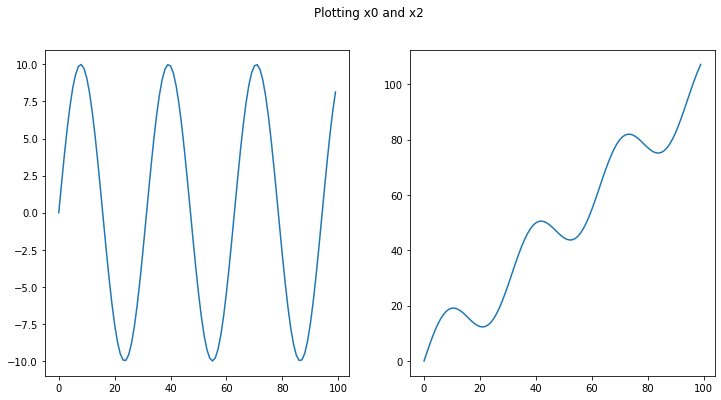

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(6)
fig.set_figwidth(12)

fig.suptitle('Plotting x0 and x2')
ax1.plot(x0)
ax2.plot(x2)
plt.show()

In [23]:
# One dimensional input
num_seq = np.array(x0).reshape(-1, 1)
num_seq[: HEAD_ROWS]

array([[0.        ],
       [1.98669331],
       [3.89418342],
       [5.64642473],
       [7.17356091],
       [8.41470985],
       [9.32039086],
       [9.8544973 ],
       [9.99573603],
       [9.73847631]])

In [24]:
num_seq.shape

(100, 1)

In [29]:
# Multi dimensional input
num_seq = np.swapaxes(np.array((x0, x1, x2)), 0, 1)
num_seq[: HEAD_ROWS]

array([[ 0.        ,  0.        ,  0.        ],
       [ 1.98669331,  1.        ,  2.98669331],
       [ 3.89418342,  2.        ,  5.89418342],
       [ 5.64642473,  3.        ,  8.64642473],
       [ 7.17356091,  4.        , 11.17356091],
       [ 8.41470985,  5.        , 13.41470985],
       [ 9.32039086,  6.        , 15.32039086],
       [ 9.8544973 ,  7.        , 16.8544973 ],
       [ 9.99573603,  8.        , 17.99573603],
       [ 9.73847631,  9.        , 18.73847631]])

In [30]:
num_seq.shape

(100, 3)

## Training Data Preparation

Input for data prep
* Input sequence
    * Would also determine how many features 
* Batch size
    * Size of minibatches to train and update weights for
* Sequence length
    * How long of a sequence do you want to retain information for
* Number of dimensions of output y
    * Time series use case normally involve predicting one variable (even though multi-label prediction can also be possible if the input is multivariate time series)
    * NLP use case normally involve predicting a multi-class output 
    
Output
* Array of size `(batch_size, sequence_length, num_features)`

In [25]:
def get_ts_X_y(seq, batch_size, seq_len, output_idx=None, lookahead=1):
    """
    Split sequence into features X and label y so that it's ready to be trained
    if output_idx is None then we're predicting on all indices of the output y 
    """
    n_features = len(seq[0])
    X = np.zeros((batch_size, seq_len, n_features))
    y = np.zeros((batch_size, n_features))
    for i in range(batch_size):
        start_idx = np.random.choice(range(len(seq) - seq_len - lookahead)) # random start
        x_obs = seq[start_idx : start_idx + seq_len]
        y_obs = seq[start_idx + seq_len + lookahead]
        X[i] = x_obs
        y[i] = y_obs
    if output_idx is not None:
        y = y[:, output_idx]
    print('Input X shape: ', X.shape)
    print('Output y shape:', y.shape)
    return X, y, n_features

In [26]:
seq_len = 15

### NLP Use Case

In [27]:
X_nlp, y_nlp, n_feat_nlp = get_ts_X_y(str_seq_ohe, BATCH_SIZE, seq_len)

Input X shape:  (32, 15, 3)
Output y shape: (32, 3)


### TS Use Case

In [31]:
X_ts, y_ts, n_feat_ts = get_ts_X_y(num_seq, BATCH_SIZE, seq_len, output_idx=2)

Input X shape:  (32, 15, 3)
Output y shape: (32,)


## Model Building

### NLP Use Case

In [32]:
nlp_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, activation='relu', input_shape=(seq_len, n_feat_nlp)),
    tf.keras.layers.Dense(n_feat_nlp, activation=tf.nn.softmax)
])

Metal device set to: Apple M1 Pro


2022-06-03 08:42:56.537523: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-03 08:42:56.537832: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [33]:
nlp_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10800     
                                                                 
 dense (Dense)               (None, 3)                 153       
                                                                 
Total params: 10,953
Trainable params: 10,953
Non-trainable params: 0
_________________________________________________________________


In [34]:
nlp_model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [35]:
logdir = os.path.join("logs/nlp", dt.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [36]:
# callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)
history = nlp_model.fit(X_nlp, y_nlp, epochs=NUM_EPOCHS, verbose=1, callbacks=[tensorboard_callback])

Epoch 1/80


2022-06-03 08:43:01.679893: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-03 08:43:02.184830: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 1.0780 - accuracy: 0.5000
Epoch 2/80
1/1 [==============================] - 0s 140ms/step - loss: 1.0734 - accuracy: 0.5000
Epoch 3/80
1/1 [==============================] - 0s 143ms/step - loss: 1.0687 - accuracy: 0.5000
Epoch 4/80
1/1 [==============================] - 0s 145ms/step - loss: 1.0640 - accuracy: 0.5000
Epoch 5/80
1/1 [==============================] - 0s 171ms/step - loss: 1.0593 - accuracy: 0.5000
Epoch 6/80
1/1 [==============================] - 0s 172ms/step - loss: 1.0546 - accuracy: 0.5000
Epoch 7/80
1/1 [==============================] - 0s 161ms/step - loss: 1.0499 - accuracy: 0.5000
Epoch 8/80
1/1 [==============================] - 0s 162ms/step - loss: 1.0451 - accuracy: 0.5000
Epoch 9/80
1/1 [==============================] - 0s 174ms/step - loss: 1.0403 - accuracy: 0.5000
Epoch 10/80
1/1 [==============================] - 0s 154ms/step - loss: 1.0353 - accuracy: 0.5000
Epoch 11/80
1/1 [================

In [38]:
%tensorboard --logdir logs/nlp

## Validations metrics

In [51]:
def get_valdn_metrics(tf_model, X_val, y_val, print_n=10, print_round=2, metrics=[]):
    # X_val[0].reshape(-1, n_steps, n_features)
    y_pred = tf_model.predict(X_val, verbose=0)
    print("====> Predicted Target")
    print(y_pred[:print_n].round(print_round))
    print("====> Actual Target")
    print(y_val[:print_n].round(print_round))
    print("====> Validation Metrics")
    for metric in metrics:
        name = metric.name if hasattr(metric, 'name') else metric.__name__
        print(name, metric(y_val, y_pred).numpy())

In [50]:
metrics = [tf.keras.losses.CategoricalCrossentropy()]
get_valdn_metrics(nlp_model, X_nlp, y_nlp, metrics=metrics)

====> Predicted Target
[[0.   0.02 0.98]
 [0.   0.   1.  ]
 [0.   0.   1.  ]
 [1.   0.   0.  ]
 [0.   1.   0.  ]
 [0.   1.   0.  ]
 [0.   1.   0.  ]
 [0.   1.   0.  ]
 [0.   1.   0.  ]
 [0.   1.   0.  ]]
====> Actual Target
[[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]
====> Validation Metrics
categorical_crossentropy 0.0016161571


### TS Use Case

#### RNN

In [52]:
ts_rnn_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(50, activation='relu', input_shape=(seq_len, n_feat_ts)),
    tf.keras.layers.Dense(1)
])

ts_rnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 50)                2700      
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 2,751
Trainable params: 2,751
Non-trainable params: 0
_________________________________________________________________


In [53]:
ts_rnn_model.compile(loss='mse', 
                     optimizer='adam',
                     metrics=[tf.metrics.MeanAbsoluteError()])

In [54]:
logdir = os.path.join("logs/ts", dt.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [55]:
# callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)
history = ts_rnn_model.fit(X_ts, y_ts, epochs=NUM_EPOCHS, verbose=1, callbacks=[tensorboard_callback])

Epoch 1/80


2022-06-03 08:48:37.207731: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 735ms/step - loss: 9603.2695 - mean_absolute_error: 90.3153
Epoch 2/80
1/1 [==============================] - 0s 104ms/step - loss: 9097.8496 - mean_absolute_error: 87.8980
Epoch 3/80
1/1 [==============================] - 0s 89ms/step - loss: 8602.8467 - mean_absolute_error: 85.4689
Epoch 4/80
1/1 [==============================] - 0s 110ms/step - loss: 8126.5010 - mean_absolute_error: 83.0647
Epoch 5/80
1/1 [==============================] - 0s 92ms/step - loss: 7675.1533 - mean_absolute_error: 80.7200
Epoch 6/80
1/1 [==============================] - 0s 92ms/step - loss: 7245.3145 - mean_absolute_error: 78.4194
Epoch 7/80
1/1 [==============================] - 0s 95ms/step - loss: 6831.0879 - mean_absolute_error: 76.1304
Epoch 8/80
1/1 [==============================] - 0s 93ms/step - loss: 6419.3086 - mean_absolute_error: 73.7977
Epoch 9/80
1/1 [==============================] - 0s 108ms/step - loss: 6008.2739 - mean_absolute_error: 71.4036

In [56]:
get_valdn_metrics(ts_rnn_model, X_ts, y_ts, 
                  metrics=[tf.metrics.MeanAbsoluteError()])

====> Predicted Target
[[45.76]
 [81.25]
 [92.8 ]
 [15.93]
 [95.31]
 [46.43]
 [48.62]
 [76.82]
 [81.75]
 [47.01]]
====> Actual Target
[50.41 81.5  96.5  14.44 99.43 43.72 46.26 80.98 80.03 50.55]
====> Validation Metrics
mean_absolute_error 3.3662376


2022-06-03 08:48:45.939901: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


#### LSTM

In [57]:
ts_lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, activation='relu', input_shape=(seq_len, n_feat_ts)),
    tf.keras.layers.Dense(1)
])

ts_lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 50)                10800     
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10,851
Trainable params: 10,851
Non-trainable params: 0
_________________________________________________________________


In [58]:
ts_lstm_model.compile(loss='mse',
                      optimizer='adam',
                      metrics=[tf.metrics.MeanAbsoluteError()])

In [59]:
logdir = os.path.join("logs/ts", dt.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [60]:
# callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)
history = ts_lstm_model.fit(X_ts, y_ts, epochs=NUM_EPOCHS, verbose=1, callbacks=[tensorboard_callback])

Epoch 1/80


2022-06-03 08:48:46.462387: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 711ms/step - loss: 731.2966 - mean_absolute_error: 24.6460
Epoch 2/80
1/1 [==============================] - 0s 156ms/step - loss: 434.2357 - mean_absolute_error: 19.4689
Epoch 3/80
1/1 [==============================] - 0s 160ms/step - loss: 333.4176 - mean_absolute_error: 17.0258
Epoch 4/80
1/1 [==============================] - 0s 170ms/step - loss: 257.5239 - mean_absolute_error: 14.8345
Epoch 5/80
1/1 [==============================] - 0s 182ms/step - loss: 204.8922 - mean_absolute_error: 13.0250
Epoch 6/80
1/1 [==============================] - 0s 177ms/step - loss: 162.7633 - mean_absolute_error: 11.3212
Epoch 7/80
1/1 [==============================] - 0s 167ms/step - loss: 127.4312 - mean_absolute_error: 9.6326
Epoch 8/80
1/1 [==============================] - 0s 167ms/step - loss: 97.3414 - mean_absolute_error: 8.0259
Epoch 9/80
1/1 [==============================] - 0s 161ms/step - loss: 72.4135 - mean_absolute_error: 6.7274
Epoch 10

For tf.keras.layers.LSTM model we need inputs with shape `[batch_size, n_timesteps, n_features]`

In [61]:
%tensorboard --logdir logs/ts

In [62]:
metrics = [tf.metrics.MeanAbsoluteError(), tf.keras.losses.MeanAbsolutePercentageError()]
get_valdn_metrics(ts_lstm_model, X_ts, y_ts, metrics=metrics)

====> Predicted Target
[[50.44]
 [81.58]
 [96.48]
 [14.43]
 [99.28]
 [43.86]
 [45.69]
 [80.75]
 [80.33]
 [50.26]]
====> Actual Target
[50.41 81.5  96.5  14.44 99.43 43.72 46.26 80.98 80.03 50.55]
====> Validation Metrics
mean_absolute_error 0.25024873
mean_absolute_percentage_error 69.43687


2022-06-03 08:49:21.057427: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


## Summary

### Similarities between Time Series and NLP Use case
* Input data dimensions
* Model training architecture (specifically everything before the last layer)

### Differences between Time Series and NLP Use case
Essentially a different ML problem - multi-class classification for NLP and regression for TS
* Model architecture: 
    * Output dimension is usuallly different - 1 for TS and n for NLP (where n is the number of classes)
    * Output layer is different - 1 linear unit for TS and n units with softmax for NLP
* Loss function and metric is different during training:
    * Loss: Categorical cross-entropy for NLP (multi-class classification) vs MSE for TS (regression)
    * Metric(s): Accuracy for NLP vs MAE or MAPE for TS 
 

## Extra Caveats
This notebook shows very simple use cases of toy problems to get you started, where:
* Patterns are very obvious and repeatable
* There are no test sets involved